## Fourier Shell Correlation
Measures the normalised cross-correlation coefficient between 2 3D volumes over shells in Fourier Space.

$$FSC(r) = \frac{\sum_{r_i \in r} F_1(r_i) \cdot F_2(r_i)^*}{\sqrt{\sum_{r_i \in r} |F_1(r_i)|^2 \cdot \sum_{r_i \in r} |F_2(r_i)|^2}}$$


I have used the implementation here (https://github.com/teamtomo/torch-fourier-shell-correlation/blob/main/src/torch_fourier_shell_correlation/fsc.py) as a guide, which uses the fftfreq_grid function found here (https://github.com/teamtomo/torch-grid-utils/blob/main/src/torch_grid_utils/fftfreq_grid.py). I chose this because it seemed smarter and more vectorized than my first attempt would have been. 


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'noise added')

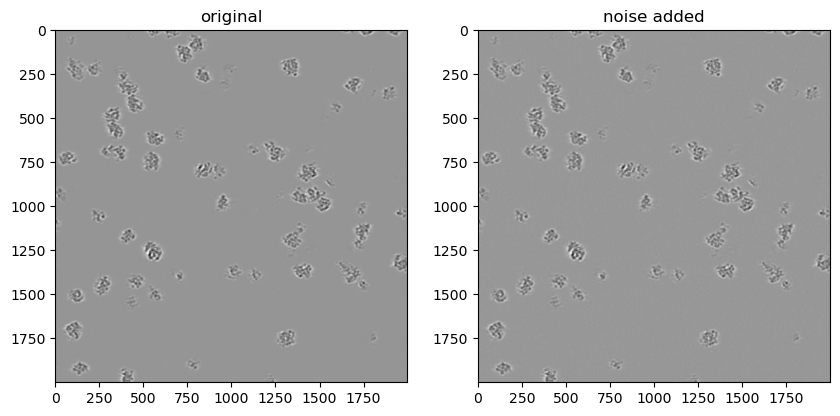

In [1]:
import torch, mrcfile, numpy as np
import matplotlib.pyplot as plt
from torch_fourier_shell_correlation import fsc as external_fsc
from fsc_mod import compute_rfsc as my_fsc

denoised_image = mrcfile.read('/Users/HenryJones/Desktop/SULI/cryocare_denoised.mrc')
denoised_tensor = torch.tensor(denoised_image)
mean = torch.zeros_like(denoised_tensor)
std = torch.ones_like(denoised_tensor) * 10

noisy_image = torch.normal(mean = mean, std = std)
del(mean, std, denoised_image)
noisy_image = noisy_image + denoised_tensor

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].imshow(denoised_tensor[100,:,:].numpy(), cmap = 'Greys_r')
ax[0].set_title('original')
ax[1].imshow(noisy_image[100,:,:].numpy(), cmap = 'Greys_r')
ax[1].set_title('noise added')

In [2]:
external_3d = external_fsc(denoised_tensor, noisy_image)

In [3]:
bins_3d, personal_3d = my_fsc(denoised_tensor, noisy_image)

torch.Size([174])


Text(0.5, 1.0, 'FSC')

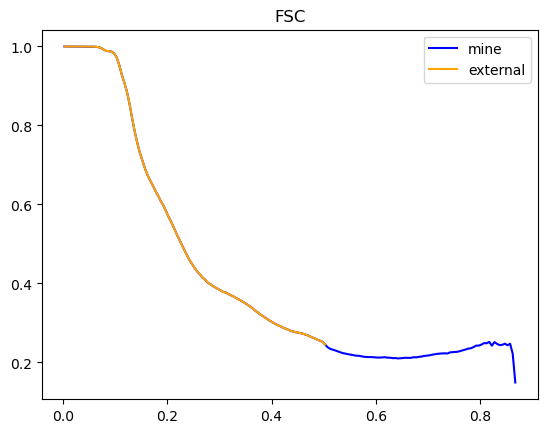

In [4]:
plt.plot(bins_3d, np.real(personal_3d.numpy()), label= 'mine', c = 'b')

bin_centers = torch.cat([torch.fft.rfftfreq(200),
                         torch.as_tensor([0.5 + torch.fft.rfftfreq(200)[1]])]) 
bin_centers = bin_centers.unfold(dimension=0, size=2, step=1)
bin_centers = torch.mean(bin_centers, dim = 1)
plt.plot(bin_centers, external_3d.numpy(), label= 'external', c = 'orange')

print(bins_3d.shape)
plt.legend()
plt.title("FSC")

### 2D Ring testing

In [5]:
fsc = external_fsc(denoised_tensor[100,:,:], noisy_image[100,:,:])
bins_2d, personal_2d = my_fsc(denoised_tensor[100,:,:], noisy_image[100,:,:])

Text(0.5, 1.0, 'FSC')

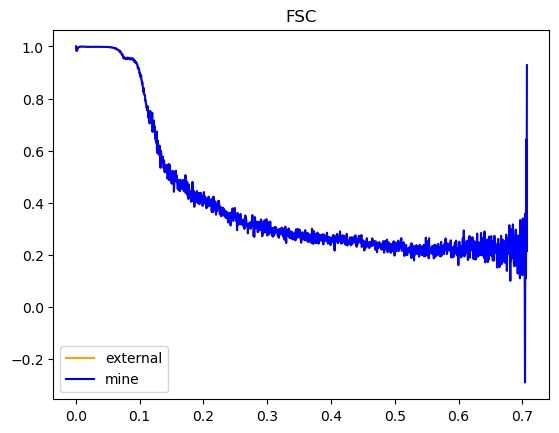

In [6]:
bin_centers = torch.cat([torch.fft.rfftfreq(2000),
                         torch.as_tensor([0.5 + torch.fft.rfftfreq(2000)[1]])]) 
bin_centers = bin_centers.unfold(dimension=0, size=2, step=1)
bin_centers = torch.mean(bin_centers, dim = 1)
plt.plot(bin_centers, fsc.numpy(), label= 'external', c = 'orange')
plt.plot(bins_2d, np.real(personal_2d.numpy()), label= 'mine', c='b')

plt.legend()
plt.title("FSC")